# Predicting Customer Churn 

## 1. The Dataset

The dataset consists of a csv file containing data on about 7,000 customers of a telecommunication company; the data also includes information about the customers' churn status. A customer is said to have churned if they cancelled their subscription to the company's service. <br>
The goal of the following analysis is to build a machine learning classification model that allows to predict which (new) customers are more likely to churn. The company could leverage this information to devise data-driven strategies to improve the customer retention rate, for example by tailoring special product offers/rates to specific groups of customers at risk of churning. <br>
This dataset is freely available on Kaggle at this [url](https://www.kaggle.com/blastchar/telco-customer-churn). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns

In [2]:
telco= pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


* __customerID__: customer ID string. 
* __gender__: customer gender (female, male)
* __SeniorCitizen__: whether the customer is a senior citizen or not (1, 0)
* __Partner__: whether the customer has a partner or not (Yes, No)
* __Dependents__: whether the customer has dependents or not (Yes, No)
* __tenure__: number of months the customer has stayed with the company
* __PhoneService__: whether the customer has a phone service or not (Yes, No)
* __MultipleLines__: whether the customer has multiple lines or not (Yes, No, No phone service)
* __InternetService__: customer’s internet service provider (DSL, Fiber optic, No)
* __OnlineSecurity__: whether the customer has online security or not (Yes, No, No internet service)
* __OnlineBackup__: whether the customer has online backup or not (Yes, No, No internet service)
* __DeviceProtection__: whether the customer has device protection or not (Yes, No, No internet service)
* __TechSupport__: whether the customer has tech support or not (Yes, No, No internet service)
* __StreamingTV__: whether the customer has streaming TV or not (Yes, No, No internet service)
* __StreamingMovies__: whether the customer has streaming movies or not (Yes, No, No internet service)
* __Contract__: the contract term of the customer (Month-to-month, One year, Two year)
* __PaperlessBilling__: whether the customer has paperless billing or not (Yes, No)
* __PaymentMethod__: the customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* __MonthlyCharges__: the amount charged to the customer monthly
* __TotalCharges__: the total amount charged to the customer
* __Churn__: whether the customer churned or not (Yes or No)

In [4]:
telco.shape

(7043, 21)

In [5]:
telco.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

## 2. Cleaning and Pre-Processing the Data

The above list shows that: 
* There are 21 predictors of which only "tenure", "monthly charges" and "total charges" are quantitative. <br>
* The remaining 18 predictors include one identifier ("customerID") and 17 categorical predictors, some of which binary, others multi-class. 
* The target variable to predict is "churn", a binary categorical variable, i.e. the customer has either churned ("Yes") or not ("No"). <br>
* The dataset is not yet ready for fitting a ML model. To begin with, not all data types are consistent with the associated variable: "Total charges" has been interpreted as a column of strings, likely because some values could not be parsed as numbers by pandas. "SeniorCitizen" is an int64, but should be a category. <br>  
First, it is good to check for the presence of NaN values: 

In [6]:
telco.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

No na values in the dataset, but there are observations in "Total charges" that cannot be parsed to numbers by pandas as applying the method pd.to_numeric() for string-to-number conversion raises an error. These observations can be retrieved using the following method. 

In [7]:
# search for strings in "TotalCharges" that do not contain numbers 
# define regular expression
expr= '1|2|3|4|5|6|7|8|9|0'
# select df observations that do not contain numbers 
telco[ ~telco['TotalCharges'].str.contains( expr, regex= True ) ].shape

(11, 21)

11 observations in the column "Total charges" do not contain numbers: they are in fact empty strings. 

In [8]:
# "TotalCharges" must be converted to float
telco['TotalCharges']= pd.to_numeric( telco['TotalCharges'], 
                                      errors= 'coerce' )
# 11 empty strings cannot be converted, and are replaced with NaN
telco['TotalCharges'].isna().sum()

11

Na values produced by the conversion of "Total Charges" to numbers are stored in another data frame ("telco_nas"). They're a small number relative to the total number of observations, so removing them should not cause significant loss of accuracy in the model (provided that the classes of the target variable are not extremely unbalanced, which is the case for this dataset). These NaN values can be imputed later on, after testing a baseline model, and added back to the dataset to check whether their inclusion after imputation improves the model accuracy. 

In [9]:
telco_nas= telco[ telco['TotalCharges'].isna() ].copy()

NaN values can now be dropped from the dataset. 

In [10]:
telco_nona= telco.dropna().copy()

"SeniorCitizen" must be converted to a category or object data type. 

In [11]:
telco_nona['SeniorCitizen'].unique()

array([0, 1])

In [12]:
telco_nona['SeniorCitizen']= telco_nona['SeniorCitizen'].replace( to_replace= {0: 'No', 1: 'Yes'} )
telco_nona.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

"customerID" identifier can be dropped. 

In [13]:
telco_nona.drop("customerID", axis= 1, inplace= True)

Replace some predictor names with shorter names for plotting. 

In [14]:
mapper = {"gender": "Gender", "SeniorCitizen": "Senior", 
          "PhoneService": "Phone", "InternetService": "Internet", 
          "tenure": "Tenure"}
telco_nona.rename(mapper= mapper, axis= 1, inplace= True)
telco_nona.dtypes

Gender               object
Senior               object
Partner              object
Dependents           object
Tenure                int64
Phone                object
MultipleLines        object
Internet             object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Unique values of categorical predictors can be listed to check their class multiplicity. 

In [15]:
# check unique values for categorical features
for item in telco_nona.select_dtypes(object).columns: 
    print( item, ' :', telco_nona[ item ].unique() )

Gender  : ['Female' 'Male']
Senior  : ['No' 'Yes']
Partner  : ['Yes' 'No']
Dependents  : ['No' 'Yes']
Phone  : ['No' 'Yes']
MultipleLines  : ['No phone service' 'No' 'Yes']
Internet  : ['DSL' 'Fiber optic' 'No']
OnlineSecurity  : ['No' 'Yes' 'No internet service']
OnlineBackup  : ['Yes' 'No' 'No internet service']
DeviceProtection  : ['No' 'Yes' 'No internet service']
TechSupport  : ['No' 'Yes' 'No internet service']
StreamingTV  : ['No' 'Yes' 'No internet service']
StreamingMovies  : ['No' 'Yes' 'No internet service']
Contract  : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  : ['Yes' 'No']
PaymentMethod  : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn  : ['No' 'Yes']


Some predictor classes can be assigned shorter names. 

In [16]:
telco_nona['Gender']= telco_nona['Gender'].replace( to_replace= {'Female': 'F', 'Male': 'M'} ) 
telco_nona['MultipleLines']= telco_nona['MultipleLines'].replace( to_replace= { 'No phone service': 'No phone' } )
telco_nona['Internet']= telco_nona['Internet'].replace( to_replace= {'Fiber optic': 'Fiber'} )
telco_nona[['OnlineSecurity', 
           'OnlineBackup', 
           'DeviceProtection', 
           'TechSupport', 
           'StreamingTV', 
           'StreamingMovies']]= telco_nona[['OnlineSecurity', 
                                            'OnlineBackup', 
                                            'DeviceProtection', 
                                            'TechSupport', 
                                            'StreamingTV', 
                                            'StreamingMovies']].replace( to_replace= {'No internet service': 'No internet'} )
telco_nona['Contract']= telco_nona['Contract'].replace( to_replace= {'Month-to-month': 'M-to-M'} )
telco_nona['PaymentMethod']= telco_nona['PaymentMethod'].replace( to_replace= {'Electronic check': 'e-check', 
                                                                               'Mailed check': 'm-check', 
                                                                               'Bank transfer (automatic)': 'b-transfer', 
                                                                               'Credit card (automatic)': 'c-card'} )

In [17]:
for item in telco_nona.select_dtypes(object).columns: 
    print( item, ' :', telco_nona[ item ].unique() )

Gender  : ['F' 'M']
Senior  : ['No' 'Yes']
Partner  : ['Yes' 'No']
Dependents  : ['No' 'Yes']
Phone  : ['No' 'Yes']
MultipleLines  : ['No phone' 'No' 'Yes']
Internet  : ['DSL' 'Fiber' 'No']
OnlineSecurity  : ['No' 'Yes' 'No internet']
OnlineBackup  : ['Yes' 'No' 'No internet']
DeviceProtection  : ['No' 'Yes' 'No internet']
TechSupport  : ['No' 'Yes' 'No internet']
StreamingTV  : ['No' 'Yes' 'No internet']
StreamingMovies  : ['No' 'Yes' 'No internet']
Contract  : ['M-to-M' 'One year' 'Two year']
PaperlessBilling  : ['Yes' 'No']
PaymentMethod  : ['e-check' 'm-check' 'b-transfer' 'c-card']
Churn  : ['No' 'Yes']


## 3. Visualizing the Relationships between Features

It is often useful to get a sense of how the data relates to the target of the predictions by plotting the relationship between some independent variables and the target variable. <br>
Additionally, it is important to know whether the target classes are balanced to accurately measure the performance of the classification model that will be built: 

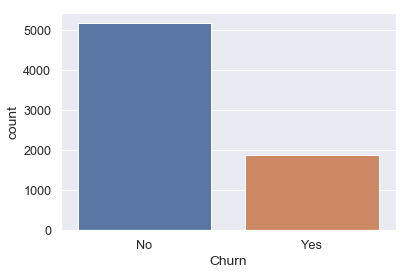

In [18]:
sns.set(font_scale= 1.15)
ax= sns.countplot(telco_nona.Churn)

In [19]:
notchurn = telco_nona[ telco_nona["Churn"]=="No" ].notnull().sum().mean()
churned = telco_nona[ telco_nona["Churn"]=="Yes" ].notnull().sum().mean()
print("Did not churn: ", notchurn)
print("Churned: ", churned)
print("'Yes'/'No' prop.: ", "{:.2f}".format(churned/notchurn*100))

Did not churn:  5163.0
Churned:  1869.0
'Yes'/'No' prop.:  36.20


The target classes are significantly unbalanced: 
* Customers who churned account for ~2/3 of total.  

Next, churns may be displayed as a function of gender to see whether male and female customers differ in their churn rate. 

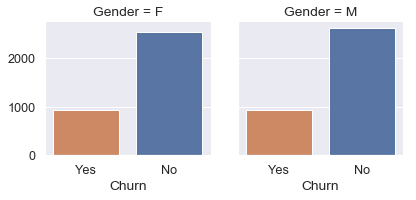

In [20]:
ax= sns.FacetGrid(telco_nona, col= "Gender", hue= "Churn")
ax= ax.map(sns.countplot, "Churn", order= ["Yes", "No"])

Interestingly, gender doesn't make much of a difference when it comes to churning the company. Churn rates for male and female customers are nearly identical. <br>
Insights into customer groups at high risk of churning may be gained by following the scheme of plotting categorical independent variables against the churn variable. Variables can be selected by making sound associations; for example, one may expect that customers on month-to-month contracts are more likely to churn as they can do so probably without incurring penalties. 

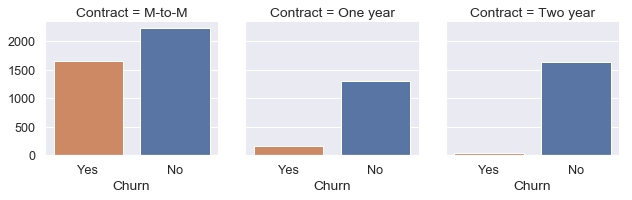

In [21]:
ax= sns.FacetGrid(telco_nona, col= "Contract",  
                  hue= "Churn", margin_titles= True)
ax= ax.map(sns.countplot, "Churn", order= ["Yes", "No"])

Indeed, contract duration seems to bear a strong association with the churn rate. Churns recorded for customers on two-year contracts are a tiny fraction.  
* Customers on __month-to-month contracts__ are at risk of churning.  

What about having or not phone and internet services? 

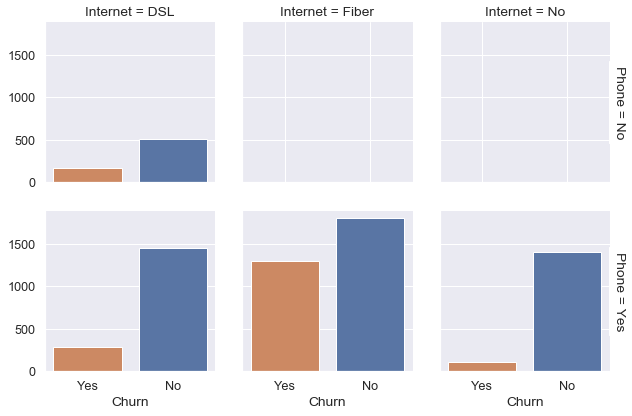

In [22]:
ax= sns.FacetGrid(telco_nona, col= "Internet", row= "Phone", 
                  hue= "Churn", margin_titles= True)
ax= ax.map(sns.countplot, "Churn", order= ["Yes", "No"])

* Customers __with phone service and internet connection via optical fiber__ are at risk of churning. 

Payment methods and the way customers are billed by the company could also make a difference. 

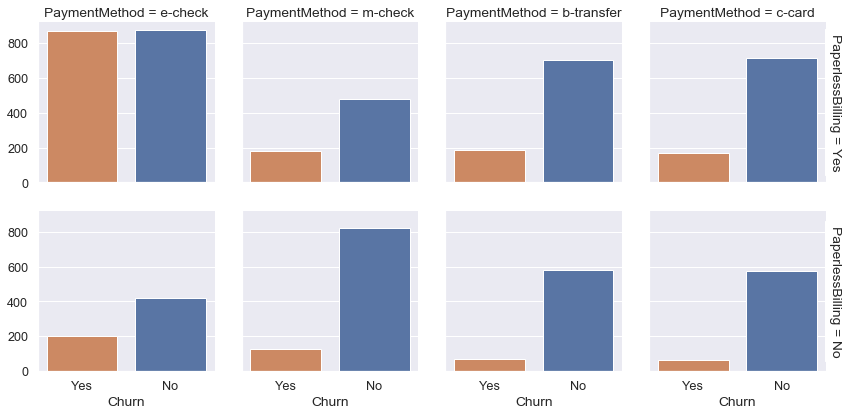

In [23]:
ax= sns.FacetGrid(telco_nona, col= "PaymentMethod", 
                  row= "PaperlessBilling", hue= "Churn", 
                  margin_titles= True)
ax= ax.map(sns.countplot, "Churn", order= ["Yes", "No"])

* Customers who opted in for __paperless billing and pay with electronic checks__ are at risk of churning. 

Quantitative predictors are also on the menu. The size of a service bill may be expected to correlate with the churn rate of customers. 

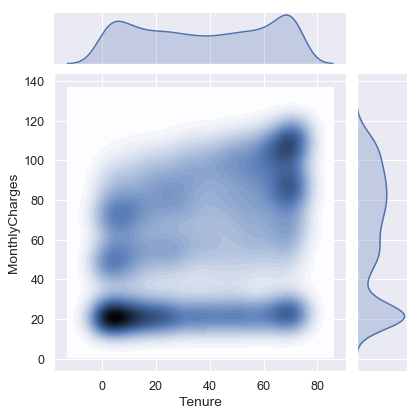

In [24]:
ax= sns.jointplot(data= telco_nona[ telco_nona["Churn"]=="No" ], 
                  x= "Tenure", 
                  y= "MonthlyCharges", 
                  kind= "kde", 
                  n_levels= 60)

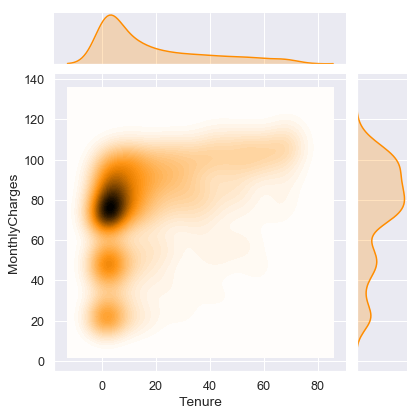

In [25]:
ax= sns.jointplot(data= telco_nona[ telco_nona["Churn"]=="Yes" ], 
                  x= "Tenure", 
                  y= "MonthlyCharges", 
                  kind= "kde", 
                  n_levels= 60, 
                  color= "darkorange")

The values of monthly charges and tenure look strongly localized for the customers who churned. <br>
* A large proportion of customers who churned were receiving __bills in excess of 60 dollars a month, and had subscribed to the company's services for less than a year__. 
* Loyal customers tend to be more evenly spread with respect to the tenure and monthly charges predictors. However, regions with high concentration of loyal customers are also present: high tenure or low monthly charges are more frequently associated with customers who did not churn. 

## 4. Baseline Model: Logistic Regression

To begin with, we can model the churn probabilities with logistic regression. The performance will then be compared to the one of several other classifiers. <br>
Categorical predictors must be encoded to numbers in order to fit a model with scikit-learn. The following code applies the simplest form of encoding to all categorical predictors in the dataset: ordinal encoding. 

In [26]:
# load libraries
# category encoding 
import category_encoders as ce
# train test splitting
from sklearn.model_selection import train_test_split
# make folds for repeated k-fold cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold
# calculate performance metrics on resamples
from sklearn.model_selection import cross_validate
# feature scaler
from sklearn.preprocessing import StandardScaler
# model 
from sklearn.linear_model import LogisticRegression
# select appropriate performance metrics 
from sklearn import metrics

In [27]:
# define predictors and target variable 
X= telco_nona.iloc[:, :-1].copy()
y= telco_nona.loc[:, "Churn"].copy()

# encode target variable
y_enc = y.replace(to_replace={"No": 0, "Yes": 1})

In [28]:
# encode predictors using ordinal encoding 
encoder= ce.OrdinalEncoder()
X_enc= encoder.fit_transform(X)

# convert int to float to avoid warning messages from scaler
X_enc= X_enc.astype(float)

# check predictors and target variable dimensionality
print("Shape of predictors dataset: ", X_enc.shape)
print("Shape of target variable dataset: ", y_enc.shape)

Shape of predictors dataset:  (7032, 19)
Shape of target variable dataset:  (7032,)


In [29]:
# check encoding labels and levels 
import churn_module as cm
cm.get_mapping(encoder)

Gender : [('F', 1), ('M', 2)]
Senior : [('No', 1), ('Yes', 2)]
Partner : [('Yes', 1), ('No', 2)]
Dependents : [('No', 1), ('Yes', 2)]
Phone : [('No', 1), ('Yes', 2)]
MultipleLines : [('No phone', 1), ('No', 2), ('Yes', 3)]
Internet : [('DSL', 1), ('Fiber', 2), ('No', 3)]
OnlineSecurity : [('No', 1), ('Yes', 2), ('No internet', 3)]
OnlineBackup : [('Yes', 1), ('No', 2), ('No internet', 3)]
DeviceProtection : [('No', 1), ('Yes', 2), ('No internet', 3)]
TechSupport : [('No', 1), ('Yes', 2), ('No internet', 3)]
StreamingTV : [('No', 1), ('Yes', 2), ('No internet', 3)]
StreamingMovies : [('No', 1), ('Yes', 2), ('No internet', 3)]
Contract : [('M-to-M', 1), ('One year', 2), ('Two year', 3)]
PaperlessBilling : [('Yes', 1), ('No', 2)]
PaymentMethod : [('e-check', 1), ('m-check', 2), ('b-transfer', 3), ('c-card', 4)]


In [30]:
# split dataset into train and test set 
# maintaining class proportions
X_train, X_test, y_train, y_test= train_test_split(X_enc, y_enc, 
                                                   stratify= y_enc, 
                                                   test_size= 0.2, 
                                                   random_state= 1987)

In [31]:
# center and scale features
scaler = StandardScaler()
X_train_scld = scaler.fit_transform(X_train)

In [32]:
# select and instantiate model: logistic regression
lg= LogisticRegression(C= 0.1, 
                       penalty= "l1", 
                       random_state= 1987, 
                       solver= "liblinear", 
                       n_jobs= 1)

In [33]:
# 10 folds repeated 10 times for cross-validation 
rskf= RepeatedStratifiedKFold(n_splits= 10, 
                              n_repeats= 10, 
                              random_state= 1987)

# peformance metrics 
scoring= {"Area under ROC curve: ": "roc_auc", 
          "Balanced accuracy:": "balanced_accuracy", 
          "F1 score:": "f1"}

# train classifier on validation folds, 
# calculate and store score for each metric 
scores = cross_validate( lg, X_train_scld, y_train, 
                         scoring= list(scoring.values()), 
                         cv= rskf, 
                         n_jobs= 4, 
                         return_train_score= False, 
                         return_estimator= False )

------
---- Logistic Regression ----
------
fit_time 0.044
score_time 0.008
test_roc_auc 0.842
test_balanced_accuracy 0.718
test_f1 0.592


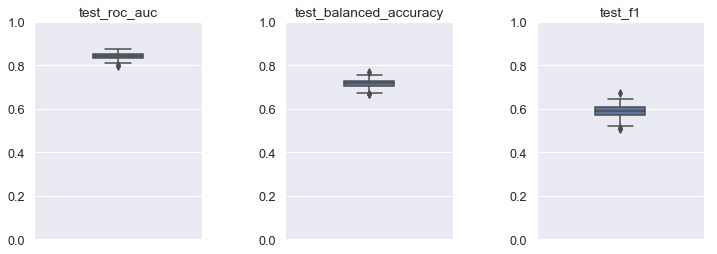

In [34]:
cm.get_cls_metrics("Logistic Regression", scores)

Various performance metrics can be calculated to assess the quality of a classifier. For example, the company may want to emphasize precision over recall, i.e. it may be more important to correctly classify all customers who do not churn (y = 0, Negatives) and less important to misclassify customers who do churn (y = 1, Positives). <br>
* Precision: TP/(TP + FP). It is high when False Positives are << True Positives, i.e. when the number of customers who do not churn, but are classified in the group of those who do, is low. 
* Recall: TP/(TP + FN). It is high when False Negatives are << True Positives, i.e when the number of customers who churn, but are classified in the group of those who don't, is low. <br>  

Thus, it could be more appropriate to test the predictive accuracy of the classifier using a $f_{\beta}$ score, where $\beta$ is a coefficient that weighs recall higher than precision if > 1. In the following, we will take the standard $f$ score and make no specific assumptions about the company's business objectives. 

### 4.1 Change Encoding Method: One-Hot Encoding 

Enconding using a more refined method could lead to an improvement of the classifier performance. Unlike dummy encoding, one-hot encoding treats categorical variables equally as the categories are not represented by scalars of ascending values. 

In [35]:
X.head()

,Gender,Senior,Partner,Dependents,Tenure,Phone,MultipleLines,Internet,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,F,No,Yes,No,1,No,No phone,DSL,No,Yes,No,No,No,No,M-to-M,Yes,e-check,29.85,29.85
1,M,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,m-check,56.95,1889.50
2,M,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,M-to-M,Yes,m-check,53.85,108.15
3,M,No,No,No,45,No,No phone,DSL,Yes,No,Yes,Yes,No,No,One year,No,b-transfer,42.30,1840.75
4,F,No,No,No,2,Yes,No,Fiber,No,No,No,No,No,No,M-to-M,Yes,e-check,70.70,151.65


In [36]:
# encode predictors using one-hot encoder 
encoder = ce.OneHotEncoder(drop_invariant= True)

X_enc = encoder.fit_transform(X)
# convert int to float to avoid warning messages from scaler
X_enc[["Tenure", "MonthlyCharges", "TotalCharges"]]= X_enc[["Tenure", "MonthlyCharges", "TotalCharges"]].astype(float)

# check predictors and target variable dimensionality
print("Shape of predictors dataset: ", X_enc.shape)
print("Shape of target variable dataset: ", y_enc.shape)

Shape of predictors dataset:  (7032, 46)
Shape of target variable dataset:  (7032,)


In [37]:
X_enc.head()

,Gender_1,Gender_2,Senior_1,Senior_2,Partner_1,Partner_2,Dependents_1,Dependents_2,Phone_1,Phone_2,...,Contract_3,PaperlessBilling_1,PaperlessBilling_2,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4,Tenure,MonthlyCharges,TotalCharges
0,1,0,1,0,1,0,1,0,1,0,...,0,1,0,1,0,0,0,1.0,29.85,29.85
1,0,1,1,0,0,1,1,0,0,1,...,0,0,1,0,1,0,0,34.0,56.95,1889.50
2,0,1,1,0,0,1,1,0,0,1,...,0,1,0,0,1,0,0,2.0,53.85,108.15
3,0,1,1,0,0,1,1,0,1,0,...,0,0,1,0,0,1,0,45.0,42.30,1840.75
4,1,0,1,0,0,1,1,0,0,1,...,0,1,0,1,0,0,0,2.0,70.70,151.65


The dataset is split using the previously selected `random_state`, which maintains the same indices for train and test sets as in the previous splitting. 

In [38]:
X_train, X_test, y_train, y_test= train_test_split(X_enc, y_enc, 
                                                   stratify= y_enc, 
                                                   test_size= 0.2, 
                                                   random_state= 1987)

Only the quantitative features are scaled to unit variance and centered. 

In [39]:
# scale
scaled_train = scaler.fit_transform(X_train.loc[:, ["Tenure", "MonthlyCharges", "TotalCharges"]])

X_train_scld = X_train.copy()
X_train_scld.loc[:, "Tenure"] = scaled_train[:, 0]
X_train_scld.loc[:, "MonthlyCharges"] = scaled_train[:, 1]
X_train_scld.loc[:, "TotalCharges"] = scaled_train[:, 2]

In [40]:
# scale test set
scaled_test = scaler.transform(X_test.loc[:, ["Tenure", "MonthlyCharges", "TotalCharges"]])

X_test_scld = X_test.copy()
X_test_scld.loc[:, "Tenure"] = scaled_test[:, 0]
X_test_scld.loc[:, "MonthlyCharges"] = scaled_test[:, 1]
X_test_scld.loc[:, "TotalCharges"] = scaled_test[:, 2]

In [41]:
X_train_scld.head()

,Gender_1,Gender_2,Senior_1,Senior_2,Partner_1,Partner_2,Dependents_1,Dependents_2,Phone_1,Phone_2,...,Contract_3,PaperlessBilling_1,PaperlessBilling_2,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4,Tenure,MonthlyCharges,TotalCharges
5963,0,1,1,0,1,0,0,1,0,1,...,0,1,0,0,1,0,0,-0.428883,0.466732,-0.275705
785,1,0,0,1,0,1,1,0,0,1,...,0,1,0,1,0,0,0,0.548912,1.509487,1.142370
2949,1,0,1,0,0,1,1,0,0,1,...,0,1,0,0,0,0,1,0.956327,-0.145284,0.439283
353,0,1,1,0,1,0,0,1,0,1,...,0,1,0,0,0,1,0,-1.162229,0.671292,-0.846217
2522,0,1,1,0,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0.834103,0.470058,0.730622


------
---- Logistic Regression ----
------
fit_time 0.153
score_time 0.013
test_roc_auc 0.841
test_balanced_accuracy 0.713
test_f1 0.584


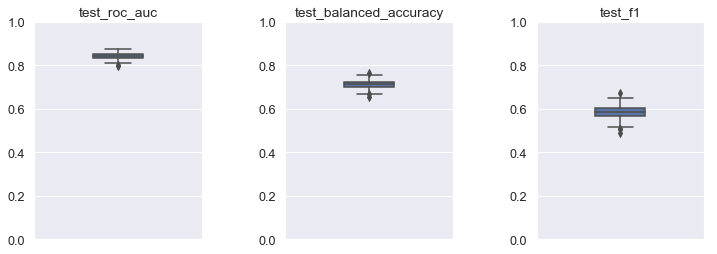

In [42]:
scores = cross_validate( lg, X_train_scld, y_train, 
                         scoring= list(scoring.values()), 
                         cv= rskf, 
                         n_jobs= 4, 
                         return_train_score= False, 
                         return_estimator= False )
cm.get_cls_metrics("Logistic Regression", scores)

No significant improvement in performance for logistic regression. We can fit the model with these parameters: 

In [43]:
lg.fit(X_train_scld, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=1,
          penalty='l1', random_state=1987, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We will compare logistic regression with the following algorithms: <br>
* Gradient Boosted Trees. 
* Support Vector Classifier. 
* K Nearest Neighbors. 

## 5. Gradient-Boosted Trees

The same instantiate-fit-predict procedure can be applied to each model after importing. <br> 
Parameters have been tuned manually to maximize the performance metrics; however, no systematic grid search has been performed. 

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, 
                                max_depth=2, random_state=1987)

------
---- GBT ----
------
fit_time 9.932
score_time 0.050
test_roc_auc 0.847
test_balanced_accuracy 0.714
test_f1 0.585


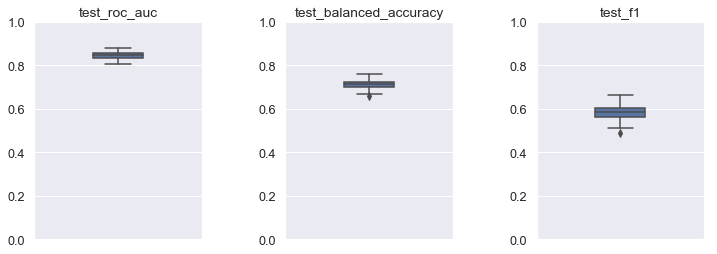

In [46]:
scores = cross_validate( gb, X_train_scld, y_train, 
                         scoring= list(scoring.values()), 
                         cv= rskf, 
                         n_jobs= 4, 
                         return_train_score= False, 
                         return_estimator= False )
cm.get_cls_metrics("GBT", scores)

In [47]:
gb.fit(X_train_scld, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=1987,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

## 6. Support Vector Classifier

In [48]:
from sklearn.svm import SVC
svc = SVC(C= 10.0, 
          kernel= "rbf", 
          gamma= "auto_deprecated", 
          shrinking= True, 
          random_state= 1987)

------
---- Support Vector Classifier ----
------
fit_time 4.199
score_time 0.586
test_roc_auc 0.802
test_balanced_accuracy 0.695
test_f1 0.556


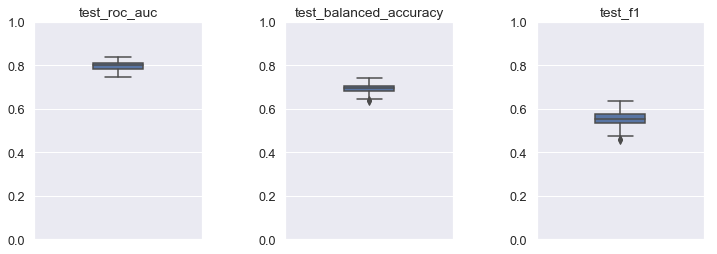

In [49]:
scores = cross_validate( svc, X_train_scld, y_train, 
                         scoring= list(scoring.values()), 
                         cv= rskf, 
                         n_jobs= 4, 
                         return_train_score= False, 
                         return_estimator= False )
cm.get_cls_metrics("Support Vector Classifier", scores)

In [50]:
svc.fit(X_train_scld, y_train)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1987,
  shrinking=True, tol=0.001, verbose=False)

## 7. KNN Classifier

In [51]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 80, 
                           p = 1, 
                           metric = "minkowski", 
                           n_jobs = 4)

------
---- K Nearest Neighbor ----
------
fit_time 0.050
score_time 1.174
test_roc_auc 0.835
test_balanced_accuracy 0.720
test_f1 0.592


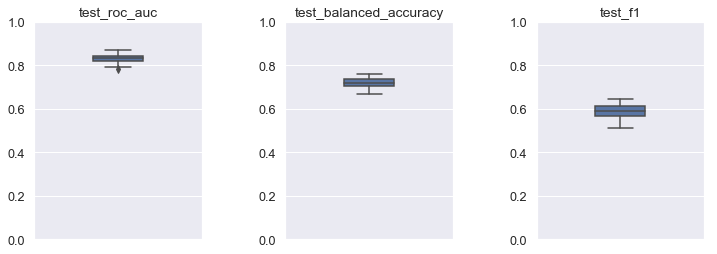

In [52]:
scores = cross_validate( knn, X_train_scld, y_train, 
                         scoring= list(scoring.values()), 
                         cv= rskf, 
                         n_jobs= 4, 
                         return_train_score= False, 
                         return_estimator= False )
cm.get_cls_metrics("K Nearest Neighbor", scores)

In [53]:
knn.fit(X_train_scld, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=80, p=1,
           weights='uniform')

## 8. Comparison of Classifiers Performance on Test Set

The F metric can be used to compare the performance of the four classifiers on the test set. 

In [54]:
from sklearn.metrics import f1_score
f_perf = dict()

In [55]:
lg_pred = lg.predict(X_test_scld)
f_perf.update({"Logistic Regression": f1_score(y_test, lg_pred)})

In [56]:
svc_pred = svc.predict(X_test_scld)
f_perf.update({"Support Vector Classifier": f1_score(y_test, svc_pred)})

In [57]:
gb_pred = gb.predict(X_test_scld)
f_perf.update({"Gradient Boosted Trees": f1_score(y_test, gb_pred)})

In [58]:
knn_pred = knn.predict(X_test_scld)
f_perf.update({"KNN": f1_score(y_test, knn_pred)})

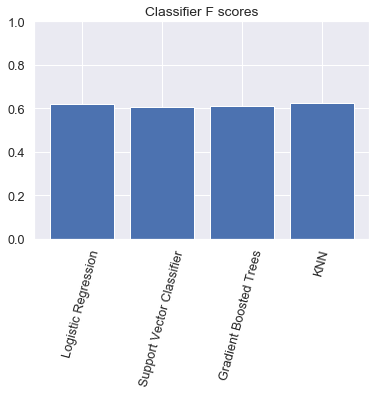

In [59]:
ax = plt.bar(range(len(f_perf)), list(f_perf.values()))
ax = plt.xticks(range(len(f_perf)), list(f_perf.keys()), rotation= 75)
ax = plt.ylim(0, 1.0)
ax = plt.title("Classifier F scores")